In [9]:
# install and import libraries


!pip install tqdm matplotlib pandas torchvision

import os
import tarfile
import shutil
from pathlib import Path
import urllib.request
from tqdm import tqdm

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:

# Set paths

data_dir = Path("./data")
archive_path = data_dir / "food-101.tar.gz"
extracted_dir = data_dir / "food-101"
prepared_dir = data_dir / "food101_imagefolder"

data_dir.mkdir(exist_ok=True, parents=True)



In [11]:


#  Download Food-101 dataset using torchvision

from torchvision.datasets import Food101

print("Downloading Food-101 dataset (this may take a few minutes)...")

# Torchvision automatically:
#  - downloads the dataset
#  - extracts it
#  - creates train/test structure
train_dataset = Food101(root='./data', split='train', download=True)
test_dataset  = Food101(root='./data', split='test', download=True)

print("Download complete!")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")




Download complete!
Training samples: 75750
Testing samples: 25250


Total Classes: 101
Example Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


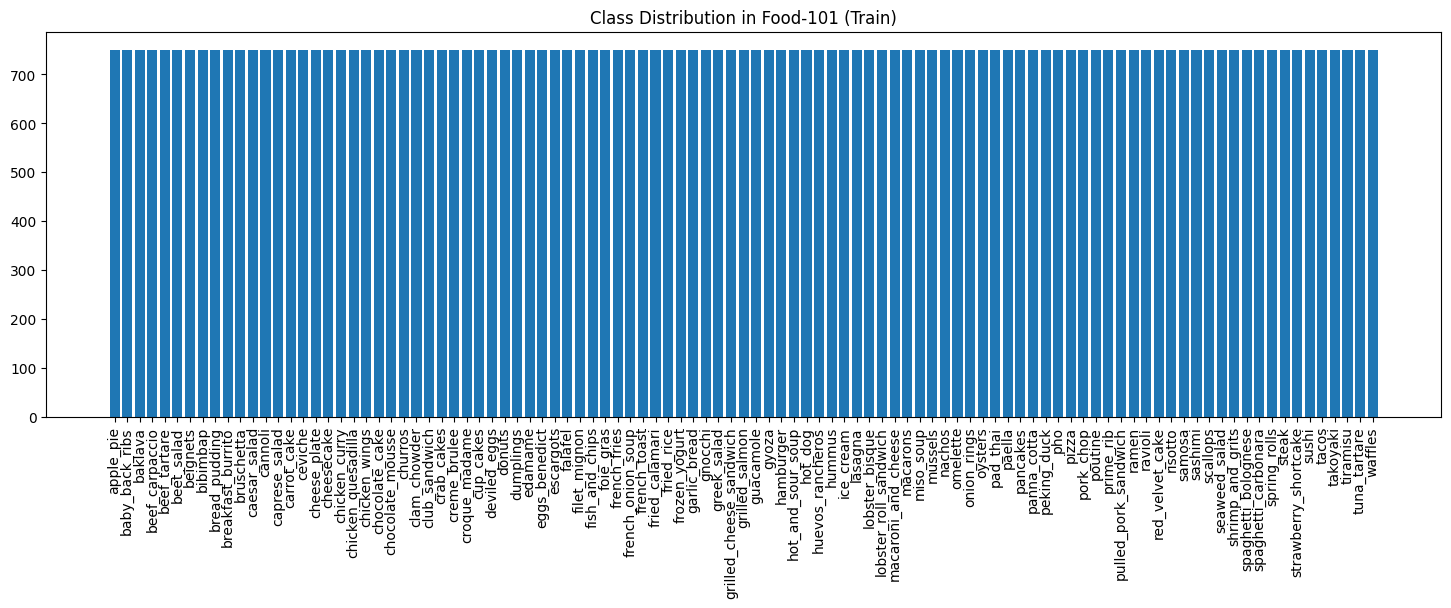

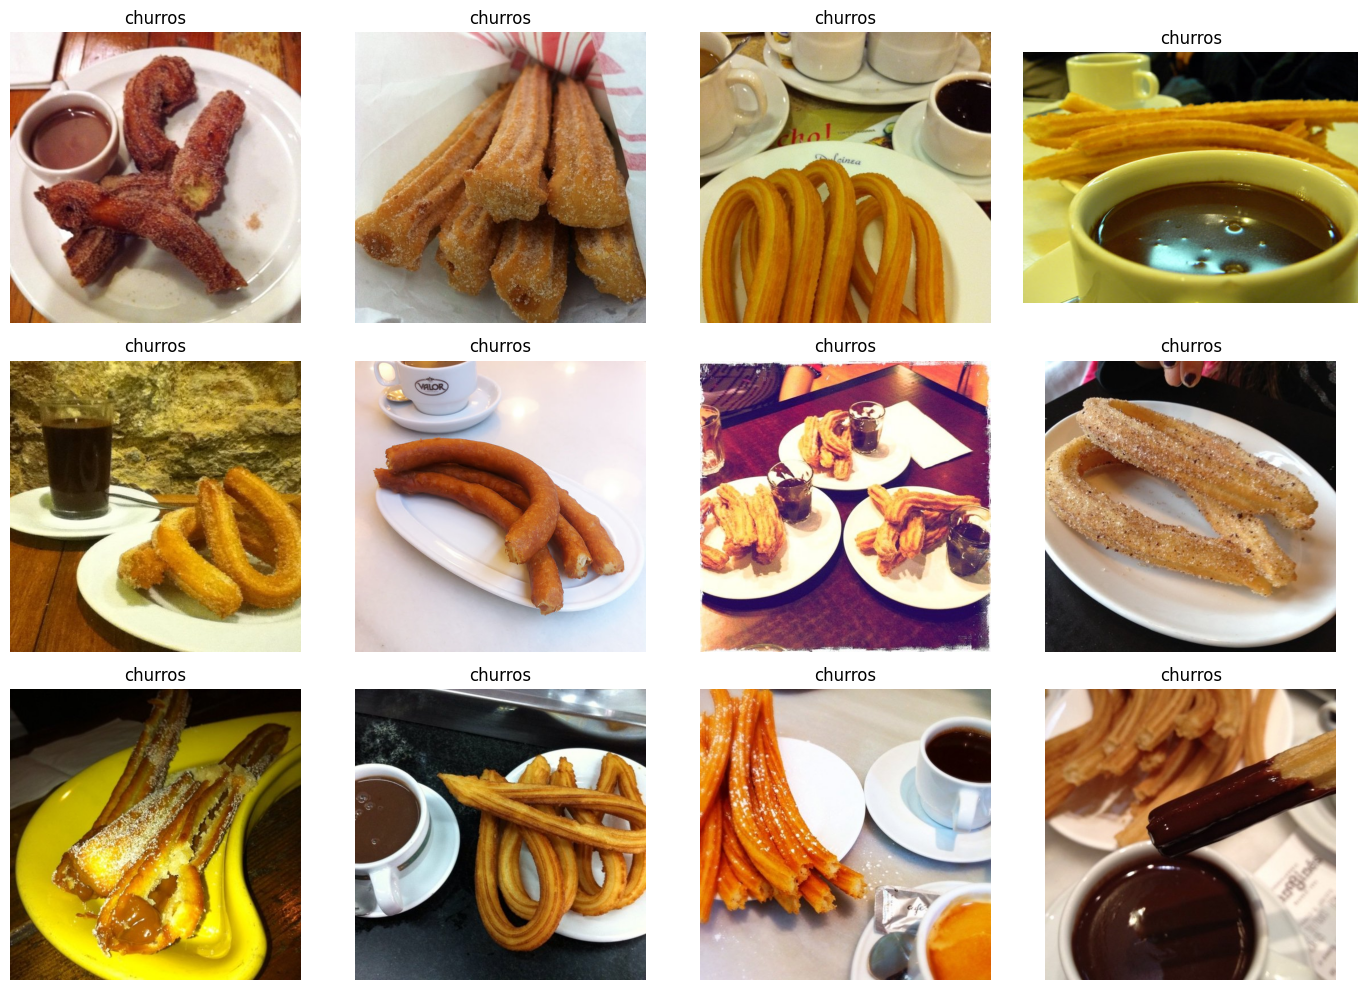

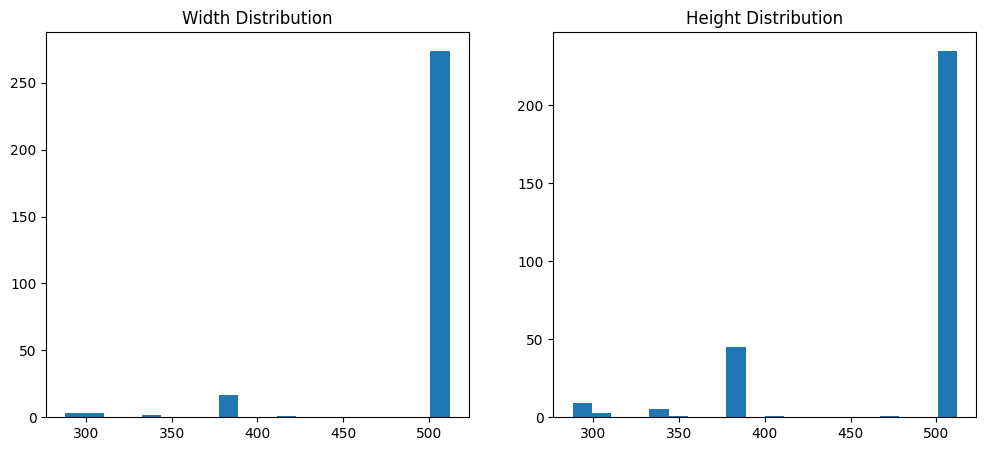

Typical Width Range: 288 - 512
Typical Height Range: 288 - 512


In [12]:
# =======================
# 📌 EDA for Food101
# =======================

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# Use the already loaded dataset (train_dataset from torchvision)
train_ds = train_dataset
test_ds = test_dataset

# Class names
class_names = train_ds.classes

print("Total Classes:", len(class_names))
print("Example Classes:", class_names[:10])


# ----------------------------------------
# 1️⃣ CLASS DISTRIBUTION
# ----------------------------------------

# Food-101 provides 750 samples per class (train split)
counts = Counter(train_ds._labels)

plt.figure(figsize=(18, 5))
plt.bar(class_names, counts.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in Food-101 (Train)")
plt.show()


# ----------------------------------------
# 2️⃣ SAMPLE IMAGES (FIXED DISPLAY CODE)
# ----------------------------------------

def show_samples(dataset, n=12):
    plt.figure(figsize=(14, 10))
    for i in range(n):
        img, label = dataset[i]

        # Convert Tensor → Numpy → (C,H,W) to (H,W,C)
        img = np.asarray(img)
        if img.shape[0] == 3:        # (3, H, W)
            img = img.transpose(1, 2, 0)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_ds)


# ----------------------------------------
# 3️⃣ IMAGE RESOLUTION CHECK (FIRST 300 IMAGES)
# ----------------------------------------

widths, heights = [], []

for i in range(300):  
    path = train_ds._image_files[i]
    img = Image.open(path)
    w, h = img.size
    widths.append(w)
    heights.append(h)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.title("Width Distribution")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.title("Height Distribution")

plt.show()

print("Typical Width Range:", min(widths), "-", max(widths))
print("Typical Height Range:", min(heights), "-", max(heights))


In [13]:
#  data augumentation & DataLoaders 

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Image size used by most pretrained CNN models (like ResNet, MobileNet, EfficientNet)
IMAGE_SIZE = 224
BATCH_SIZE = 32

# ----------------------------------------------
# 1. Define image transformations
# ----------------------------------------------

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),

    # Normalization values from ImageNet (for pretrained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply transforms to datasets loaded in Cell 3
train_dataset.transform = train_transform
test_dataset.transform = test_transform

# ----------------------------------------------
# 2. Create DataLoaders
# ----------------------------------------------

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders ready!")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoaders ready!
Train batches: 2368
Test batches: 790


In [14]:
# Define Model (ResNet-18 Transfer Learning) 

import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 101  # Food-101 dataset has 101 classes

# Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer (fully connected)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# If GPU available, move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model ready!")
print(model)


Model ready!
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

In [15]:
#  Loss Function, Optimizer, Scheduler 

import torch.optim as optim

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: only train the final layer (fc layer)
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler — reduces LR every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Training components ready:")
print(" - Loss: CrossEntropyLoss")
print(" - Optimizer: AdamW")
print(" - Scheduler: StepLR (step_size=5, gamma=0.1)")


Training components ready:
 - Loss: CrossEntropyLoss
 - Optimizer: AdamW
 - Scheduler: StepLR (step_size=5, gamma=0.1)


In [16]:
#  Train / Validation Split 

from torch.utils.data import random_split, DataLoader

val_ratio = 0.1  # 10% validation

total_train = len(train_dataset)
train_size = int((1 - val_ratio) * total_train)
val_size = total_train - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f"Total Training Images: {total_train}")
print(f"Train set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


Total Training Images: 75750
Train set size: 68175
Validation set size: 7575


In [17]:
print(train_dataset.classes)



['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [8]:
# Training & Validation Loop 

import torch
import numpy as np
from tqdm import tqdm

EPOCHS = 10   # you can increase later
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\n----- Epoch {epoch+1}/{EPOCHS} -----")

    
    #         TRAINING
    
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    scheduler.step()

    
    #        VALIDATION
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    
    #     PRINT RESULTS
    
    print(f"Training Loss: {train_loss/len(train_loader):.4f},  "
          f"Training Acc: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss/len(val_loader):.4f},  "
          f"Validation Acc: {val_acc:.4f}")

    
    #     SAVE BEST MODEL

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✨ Saved Best Model!")

print("\nTraining Completed!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")



----- Epoch 1/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:18<00:00,  1.60s/it]


Training Loss: 2.7732,  Training Acc: 0.3506
Validation Loss: 2.2933,  Validation Acc: 0.4375
✨ Saved Best Model!

----- Epoch 2/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:05<00:00,  1.54s/it]


Training Loss: 2.2415,  Training Acc: 0.4475
Validation Loss: 2.2065,  Validation Acc: 0.4643
✨ Saved Best Model!

----- Epoch 3/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [05:56<00:00,  1.50s/it]


Training Loss: 2.1615,  Training Acc: 0.4646
Validation Loss: 2.1797,  Validation Acc: 0.4648
✨ Saved Best Model!

----- Epoch 4/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:05<00:00,  1.54s/it]


Training Loss: 2.1233,  Training Acc: 0.4721
Validation Loss: 2.1270,  Validation Acc: 0.4791
✨ Saved Best Model!

----- Epoch 5/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:08<00:00,  1.55s/it]


Training Loss: 2.0905,  Training Acc: 0.4806
Validation Loss: 2.1323,  Validation Acc: 0.4758

----- Epoch 6/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:07<00:00,  1.55s/it]


Training Loss: 1.9032,  Training Acc: 0.5208
Validation Loss: 2.0108,  Validation Acc: 0.5005
✨ Saved Best Model!

----- Epoch 7/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:08<00:00,  1.55s/it]


Training Loss: 1.8931,  Training Acc: 0.5230
Validation Loss: 1.9915,  Validation Acc: 0.5081
✨ Saved Best Model!

----- Epoch 8/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:05<00:00,  1.54s/it]


Training Loss: 1.8846,  Training Acc: 0.5278
Validation Loss: 2.0094,  Validation Acc: 0.5050

----- Epoch 9/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [06:03<00:00,  1.53s/it]


Training Loss: 1.8839,  Training Acc: 0.5265
Validation Loss: 2.0034,  Validation Acc: 0.4960

----- Epoch 10/10 -----


Validating: 100%|████████████████████████████████████████████████████████████████████| 237/237 [05:57<00:00,  1.51s/it]

Training Loss: 1.8748,  Training Acc: 0.5285
Validation Loss: 2.0082,  Validation Acc: 0.5017

Training Completed!
Best Validation Accuracy: 0.5081


Macro F1-score: 0.4893312607297276

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.17      0.24        86
           1       0.47      0.43      0.45        67
           2       0.39      0.41      0.40        74
           3       0.53      0.49      0.51        80
           4       0.34      0.38      0.36        74
           5       0.43      0.55      0.48        66
           6       0.56      0.65      0.60        68
           7       0.62      0.78      0.69        68
           8       0.30      0.18      0.22        79
           9       0.43      0.42      0.42        74
          10       0.35      0.22      0.27        68
          11       0.46      0.61      0.53        74
          12       0.45      0.57      0.50        65
          13       0.45      0.48      0.46        73
          14       0.47      0.37      0.41        76
          15       0.29      0.29      0.29        76
          16       0.4

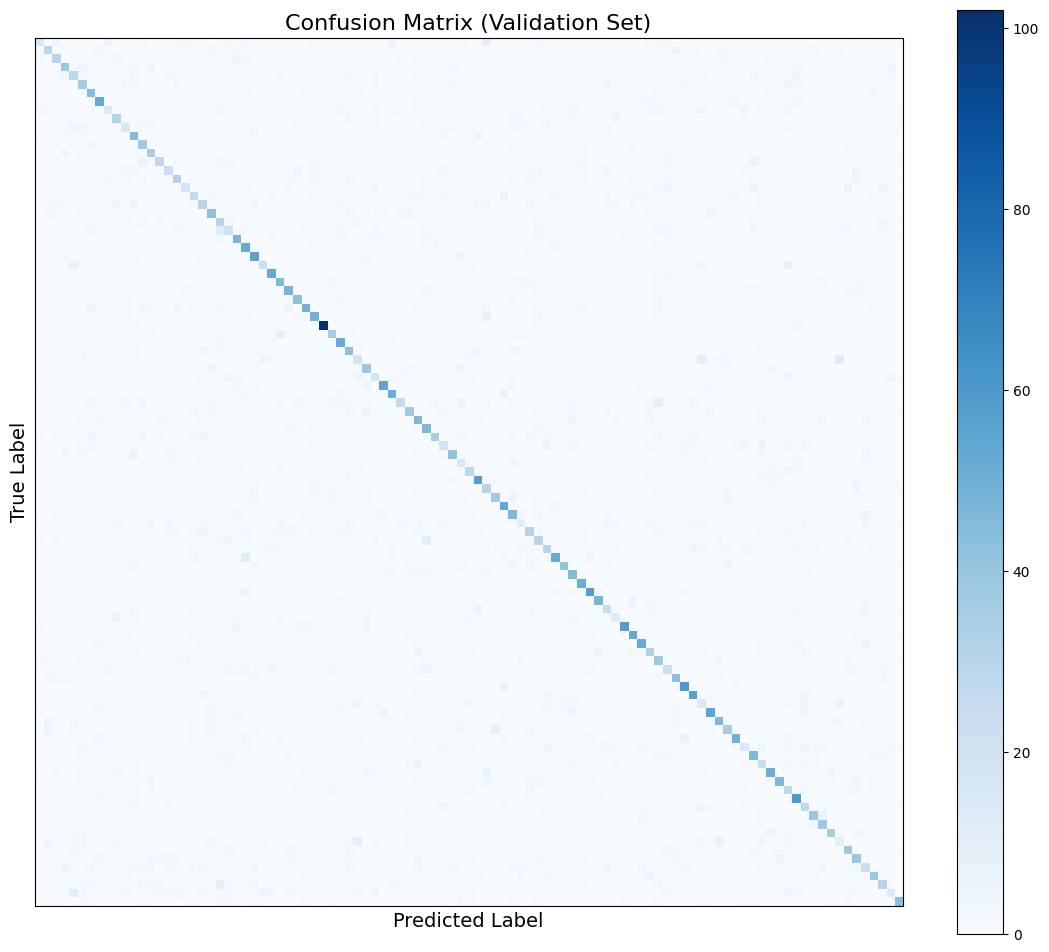

In [9]:
# Evaluation (Macro F1 + Confusion Matrix Plot) 

from sklearn.metrics import f1_score, confusion_matrix, classification_report
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load best saved model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute F1-score (macro)
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print("Macro F1-score:", macro_f1)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)


#  Plot Confusion Matrix 

plt.figure(figsize=(14, 12))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)", fontsize=16)
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Reduce tick clutter (101 classes → too many labels)
plt.xticks([])
plt.yticks([])

plt.show()


C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


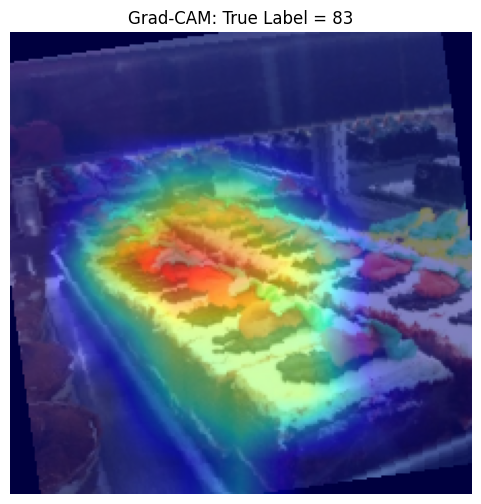

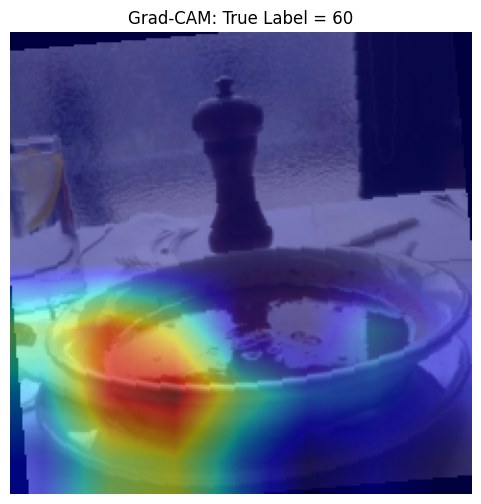

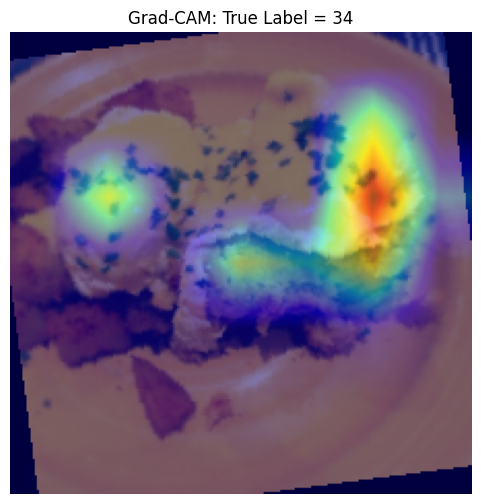

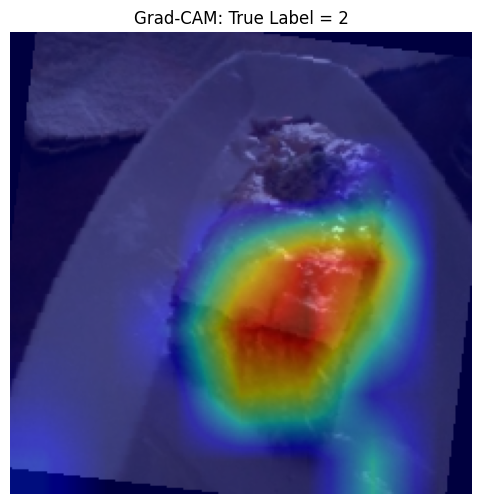

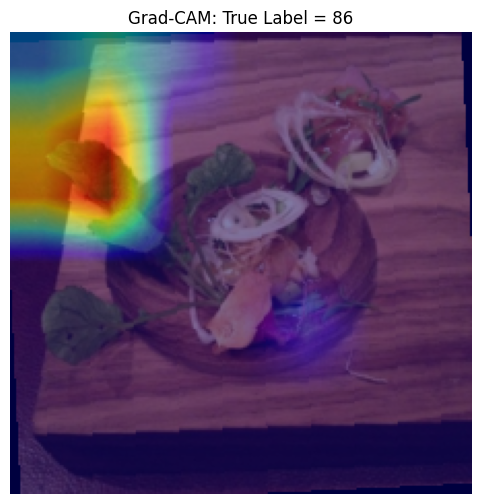

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. Unfreeze last conv block
# -------------------------
for param in model.layer4.parameters():
    param.requires_grad = True

# -------------------------
# 2. Grad-CAM Functions
# -------------------------
gradients = []
activations = []

def save_activations(module, input, output):
    activations.append(output)

def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def generate_gradcam(model, image, target_class=None):
    model.eval()
    gradients.clear()
    activations.clear()
    
    # Last conv layer
    final_conv = model.layer4
    
    # Register hooks
    final_conv.register_forward_hook(save_activations)
    final_conv.register_backward_hook(save_gradients)  # regular backward hook

    # Ensure input requires grad
    image.requires_grad_()
    
    # Forward pass
    output = model(image)
    
    # Target class
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)
    
    # Grad-CAM computation
    grads = gradients[0]           # (1, C, H, W)
    acts = activations[0]          # (1, C, H, W)
    
    weights = grads.mean(dim=(2,3), keepdim=True)   # global average pooling
    cam = (weights * acts).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # normalize
    return cam

# -------------------------
# 3. Visualization
# -------------------------
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def show_gradcam(model, dataset, indices=[0,1,2,3,4]):
    for idx in indices:
        img, label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)
        
        # Generate Grad-CAM
        cam = generate_gradcam(model, input_img)
        
        # Convert image back to displayable
        img_disp = inv_normalize(img).permute(1,2,0).cpu().numpy()
        img_disp = np.clip(img_disp, 0, 1)
        
        # Overlay CAM
        plt.figure(figsize=(6,6))
        plt.imshow(img_disp)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title(f"Grad-CAM: True Label = {label}")
        plt.axis('off')
        plt.show()

# -------------------------
# 4. Run Grad-CAM on validation images
# -------------------------
show_gradcam(model, val_subset, indices=[0,1,2,3,4])
